In [169]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Import required Libraries

In [170]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from kneed import KneeLocator
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import sys

In [171]:
import warnings
warnings.filterwarnings('ignore')

In [172]:
plt.style.use("https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle")

#### Import modules

In [173]:
sys.path.append(os.path.abspath(os.path.join('../src')))
#from preprocessing import PreProcess
#from overview import Overview
#from plot import Plot
from logger import Logger

In [174]:
#Initialize logger
logger = Logger("userEngagement.log").get_logger()
logger.info("Initialized userEngagement.py logger")

#### Import the Data

In [175]:
# df = pd.read_excel('../data/Week1_challenge_data_source.xlsx')
df_org = pd.read_csv('../data/cleaned_data.csv')

In [176]:
df = df_org.copy()

Data overview

In [177]:
df.head()

,bearer_id,start,start_ms,end,end_ms,dur._(ms),imsi,msisdn/number,imei,last_location_name,...,total_ul_(bytes),total_dl_(bytes),social_media_(bytes),google_(bytes),email_(bytes),youtube_(bytes),netflix_(bytes),gaming_(bytes),other_(bytes),total_data_(bytes)
0,1.311448e+19,4/4/2019 12:01,770.0,4/25/2019 14:35,662.0,0.996516,2.082014e+14,3.366496e+10,3.552121e+13,9.16456699548519E+015,...,0.771197,0.778526,11.036410,1.738451,1.852706,1.793016,1.859441,1.901342,1.817976,1.549723
1,1.311448e+19,4/9/2019 13:04,235.0,4/25/2019 8:15,606.0,0.944446,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,0.886427,0.933206,9.827664,1.785130,1.775150,1.977796,1.963669,1.763184,1.954035,1.819634
2,1.311448e+19,4/9/2019 17:42,1.0,4/25/2019 11:58,652.0,0.944006,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,0.687728,0.758117,11.590792,1.910091,1.951614,1.954365,1.883525,1.600057,1.824534,1.445845
3,1.311448e+19,4/10/2019 0:31,486.0,4/25/2019 7:36,171.0,0.938611,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,0.820953,0.986552,10.364737,1.950439,1.896513,1.963038,1.737034,1.962097,1.968303,1.807506
4,1.311448e+19,4/12/2019 20:10,565.0,4/25/2019 10:40,954.0,0.903820,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,0.785599,0.904707,11.710516,1.872954,1.821555,1.955388,1.679468,1.839929,1.950780,1.690306


#### User Engagement Analysis

##### Total data volume (in Bytes) during this session for each application


In [178]:
df["social_media"] = df["social_media_dl_(bytes)"] + df['social_media_ul_(bytes)']
df["google"] = df["google_dl_(bytes)"] + df["google_ul_(bytes)"]
df['email'] = df["email_dl_(bytes)"] + df["email_ul_(bytes)"]
df['youtube'] = df["youtube_dl_(bytes)"] + df["youtube_ul_(bytes)"]
df['netflix'] = df["netflix_dl_(bytes)"] + df["netflix_ul_(bytes)"]
df["gaming"] = df["gaming_dl_(bytes)"] + df["gaming_ul_(bytes)"]
df['other'] = df["other_dl_(bytes)"]+df["other_ul_(bytes)"]
df['total_data'] = df['total_dl_(bytes)'] + df['total_ul_(bytes)']

In [179]:
df.columns

Index(['bearer_id', 'start', 'start_ms', 'end', 'end_ms', 'dur._(ms)', 'imsi',
       'msisdn/number', 'imei', 'last_location_name', 'avg_rtt_dl_(ms)',
       'avg_rtt_ul_(ms)', 'avg_bearer_tp_dl_(kbps)', 'avg_bearer_tp_ul_(kbps)',
       'dl_tp_<_50_kbps_(%)', '50_kbps_<_dl_tp_<_250_kbps_(%)',
       '250_kbps_<_dl_tp_<_1_mbps_(%)', 'dl_tp_>_1_mbps_(%)',
       'ul_tp_<_10_kbps_(%)', '10_kbps_<_ul_tp_<_50_kbps_(%)',
       '50_kbps_<_ul_tp_<_300_kbps_(%)', 'ul_tp_>_300_kbps_(%)',
       'activity_duration_dl_(ms)', 'activity_duration_ul_(ms)', 'dur._(ms).1',
       'handset_manufacturer', 'handset_type', 'nb_of_sec_with_vol_dl_<_6250b',
       'nb_of_sec_with_vol_ul_<_1250b', 'social_media_dl_(bytes)',
       'social_media_ul_(bytes)', 'google_dl_(bytes)', 'google_ul_(bytes)',
       'email_dl_(bytes)', 'email_ul_(bytes)', 'youtube_dl_(bytes)',
       'youtube_ul_(bytes)', 'netflix_dl_(bytes)', 'netflix_ul_(bytes)',
       'gaming_dl_(bytes)', 'gaming_ul_(bytes)', 'other_dl_(bytes)',


Aggregate the number of session durations, total session duration, & total data for each user

In [180]:
df = df.rename( columns={'bearer_id': 'sessions'})

In [181]:
user_engagement = df.groupby('msisdn/number').agg({'sessions': 'count', 'dur._(ms)': 'sum', 'total_data': 'sum'})

In [182]:
user_engagement.head()

,sessions,dur._(ms),total_data
msisdn/number,,,
3.360100e+10,1,0.502300,1.751134
3.360100e+10,1,0.581407,1.350465
3.360100e+10,1,0.528418,1.691663
3.360101e+10,1,0.349441,1.425098
3.360101e+10,2,0.343253,3.558224


#### 2.1 Users data analysis

Get the top 10 users with the highest total data volume, sessions, & session duration

Aggregate the above metrics per customer id (MSISDN) and report the top 10 customers per engagement metric 


In [183]:
user_engagement.shape

(106856, 3)

In [184]:
# user_engagement = user_engagement[user_engagement.index.str.contains("3.366371e+10") == False]
user_engagement.drop(33663706799.0, axis=0, inplace=True)

In [185]:
sessions = user_engagement.nlargest(10, "sessions")['sessions']
duration = user_engagement.nlargest(10, "dur._(ms)")['dur._(ms)']
total_data = user_engagement.nlargest(10, "total_data")['total_data']


In [186]:
sesssions_df = pd.DataFrame()
sesssions_df['User_ID'] = sessions.index
sesssions_df['Sessions'] = sessions.values
durations_df = pd.DataFrame()
durations_df['User_ID'] = duration.index
durations_df['duration'] = duration.values
total_data_df = pd.DataFrame()
total_data_df['User_ID'] = total_data.index
total_data_df['total_data'] = total_data.values

In [187]:
sesssions_df.head()

,User_ID,Sessions
0,3.362632e+10,18
1,3.361489e+10,17
2,3.362578e+10,17
3,3.365973e+10,16
4,3.367588e+10,15


In [188]:
durations_df.head()


,User_ID,duration
0,3.362578e+10,14.843524
1,3.362632e+10,12.989967
2,3.361489e+10,12.871815
3,3.376054e+10,11.266070
4,3.366716e+10,10.296854


In [189]:
total_data_df.head()

,User_ID,total_data
0,3.362632e+10,28.335924
1,3.362578e+10,27.839376
2,3.361489e+10,27.478626
3,3.376054e+10,25.162286
4,3.365973e+10,25.139605


[]

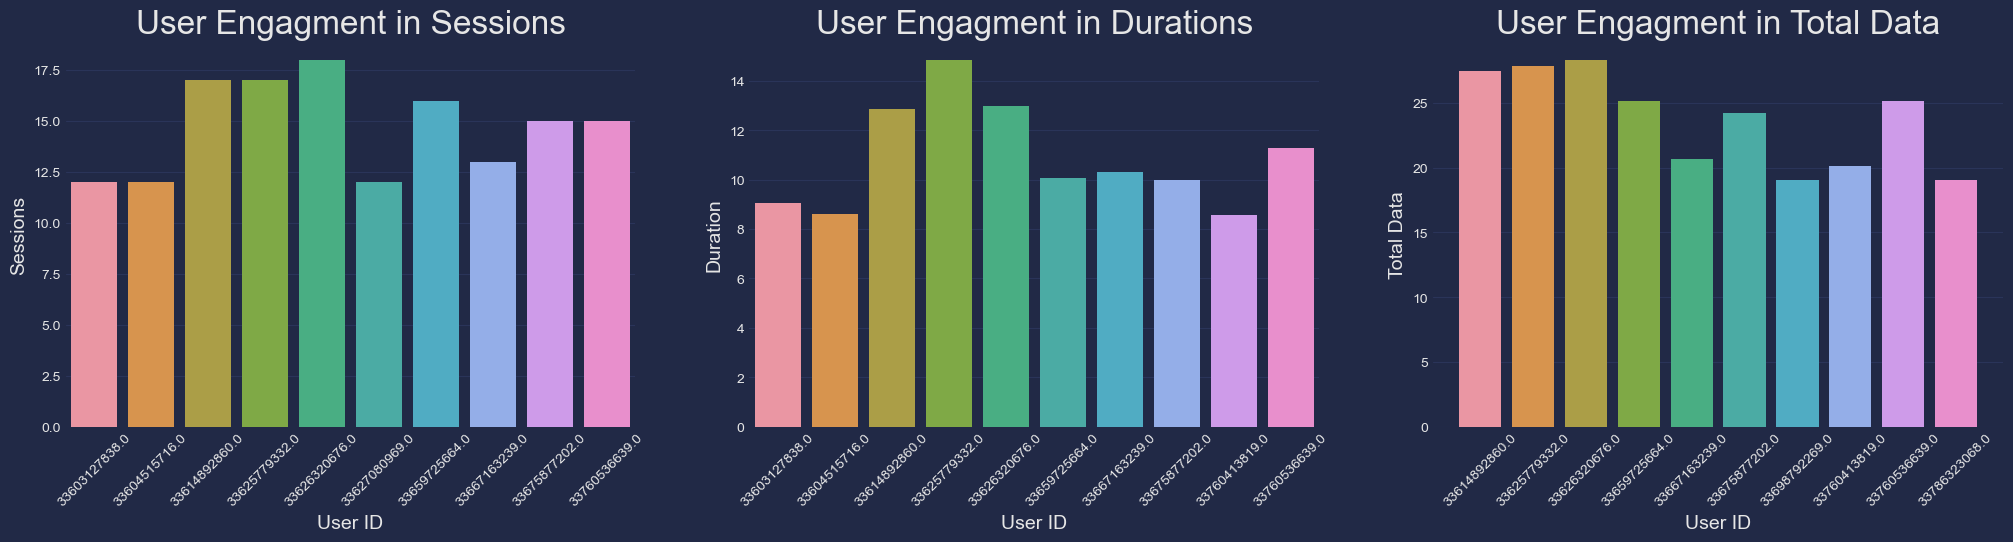

In [190]:
f, axes = plt.subplots(1, 3, figsize=(25, 5))
ax1 = sns.barplot(data=sesssions_df, x='User_ID', orient='v', y='Sessions', ax=axes[0])
ax2 = sns.barplot(data=durations_df, x='User_ID',orient='v', y='duration', ax=axes[1])
ax3 = sns.barplot(data=total_data_df, x='User_ID',orient='v', y='total_data', ax=axes[2])
ax1.set_xticklabels(ax1.xaxis.get_majorticklabels(), rotation=45)
ax2.set_xticklabels(ax2.xaxis.get_majorticklabels(), rotation=45)
ax3.set_xticklabels(ax3.xaxis.get_majorticklabels(), rotation=45)
ax1.set_xlabel( "User ID" , size = 14 )  
ax1.set_ylabel( "Sessions" , size = 14 ) 
ax1.set_title( "User Engagment in Sessions" , size = 24 ) 
ax2.set_xlabel( "User ID" , size = 14 )  
ax2.set_ylabel( "Duration" , size = 14 ) 
ax2.set_title( "User Engagment in Durations" , size = 24 ) 
ax3.set_xlabel( "User ID" , size = 14 )  
ax3.set_ylabel( "Total Data" , size = 14 ) 
ax3.set_title( "User Engagment in Total Data" , size = 24 ) 


plt.plot()


Normalize each engagement metric and run a k-means (k=3) to classify customers in three groups of engagement. 


In [123]:
from sklearn.preprocessing import Normalizer

def normalizer(df, columns):
    norm = Normalizer()
    # normalize the exponential data with boxcox
    normalized_data = norm.fit_transform(df)

    # plot both together to compare
    fig, ax=plt.subplots(1,2, figsize=(10, 6))
    sns.histplot(df, ax=ax[0])
    ax[0].set_title("Original Data")
    sns.histplot(normalized_data[0], ax=ax[1])
    ax[1].set_title("Normalized data")
    return pd.DataFrame(norm.fit_transform(df), columns=columns)

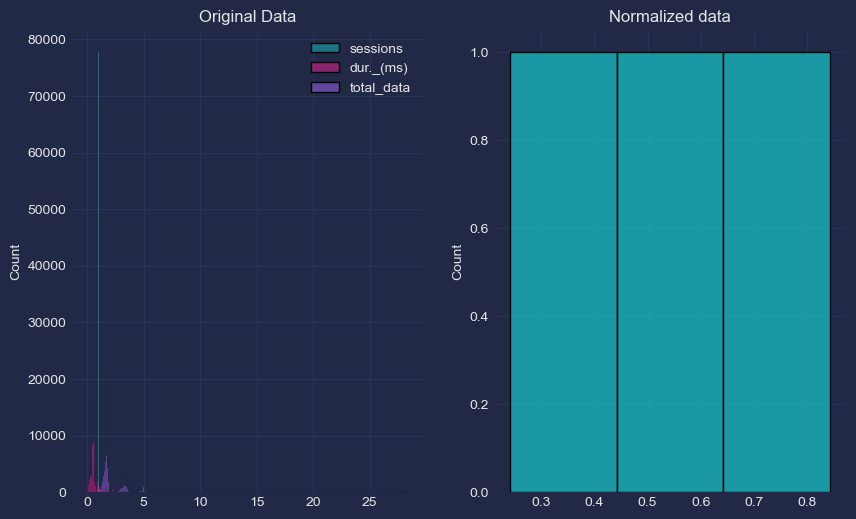

In [124]:
normalized_user_engagement = normalizer(user_engagement, ['sessions', 'dur._(ms)', 'total_data'] )

In [125]:
normalized_user_engagement.head()

,sessions,dur._(ms),total_data
0,0.481193,0.241704,0.842634
1,0.562385,0.326974,0.759481
2,0.491417,0.259674,0.831312
3,0.563167,0.196794,0.802568
4,0.488258,0.083798,0.868667


In [126]:
normalized_user_engagement.describe()

,sessions,dur._(ms),total_data
count,106855.000000,106855.000000,106855.000000
mean,0.516132,0.223813,0.822405
std,0.039218,0.067179,0.033396
min,0.428995,0.000000,0.458651
25%,0.488358,0.190006,0.807443
50%,0.508575,0.232999,0.828997
75%,0.535401,0.267627,0.845068
max,0.794010,0.511353,0.889744


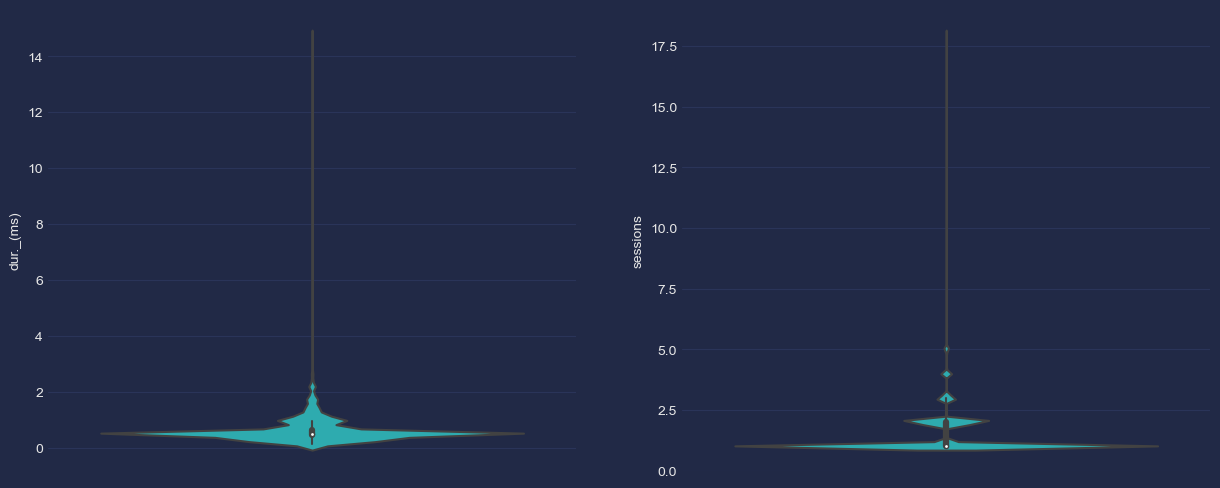

In [127]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.violinplot(y=user_engagement["dur._(ms)"])
# sns.boxplot(y=user_engagement["dur._(ms)"], color="red")
plt.subplot(1,2,2)
sns.violinplot(y=user_engagement["sessions"])
# sns.boxplot(y=user_engagement["total_data"])
plt.show()

Most of the duration,and the number of sessions lies between 1 - 2 

K-means clustering (K=3)

In [128]:
normalized__eng = normalized_user_engagement.copy()

In [129]:
kmeans = KMeans(init="random",n_clusters=3,n_init=10,max_iter=300,random_state=42)
label = kmeans.fit_predict(normalized__eng)
centroids = kmeans.cluster_centers_

plot the data points in the 3 clusters

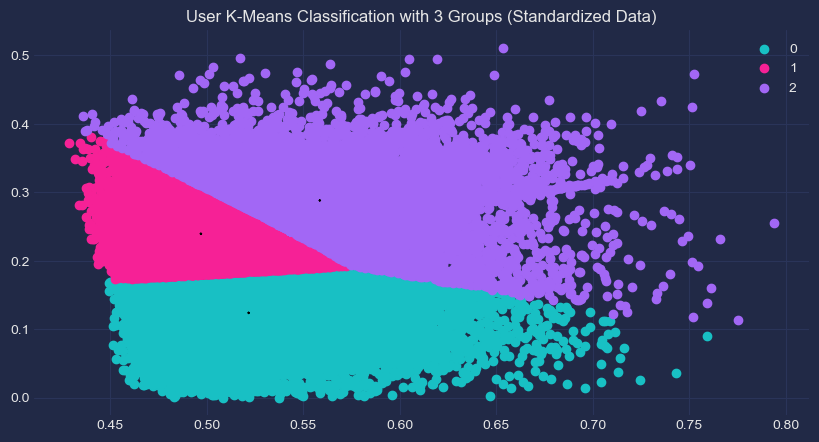

In [130]:
lables_unique = np.unique(label)
#plotting the results:
plt.figure(figsize=(10,5))
plt.title('User K-Means Classification with 3 Groups (Standardized Data)')
for i in lables_unique:
    plt.scatter(normalized__eng[label == i].iloc[:,0] , normalized__eng[label == i].iloc[:,1], marker='o', label = i)
plt.scatter(centroids[:,0] , centroids[:,1],centroids[:,2], marker='x', color = 'black')
plt.legend()
plt.show()

In [131]:
logger.info(f'# Centroids of the clustering:\n{centroids}')
logger.info(f'# The number of iterations required to converge: {kmeans.inertia_}')
logger.info(f'# The number of iterations required to converge: {kmeans.n_iter_}')

Compute the minimum, maximum, average & total non- normalized metrics for each cluster. Interpret your results visually with accompanying text explaining your findings.


In [132]:
normalized__eng.head()

,sessions,dur._(ms),total_data
0,0.481193,0.241704,0.842634
1,0.562385,0.326974,0.759481
2,0.491417,0.259674,0.831312
3,0.563167,0.196794,0.802568
4,0.488258,0.083798,0.868667


In [133]:
clustered_Df = pd.DataFrame()
clustered_Df['data_index'] = normalized__eng.index.values
clustered_Df['cluster'] = kmeans.labels_

In [134]:
clustered_Df.cluster.value_counts()

1    59339
0    24279
2    23237
Name: cluster, dtype: int64

In [135]:
u_eng = user_engagement.copy()

In [136]:
u_eng.insert(0, 'cluster', kmeans.labels_)
u_eng.head(5)

,cluster,sessions,dur._(ms),total_data
msisdn/number,,,,
3.360100e+10,1,1,0.502300,1.751134
3.360100e+10,2,1,0.581407,1.350465
3.360100e+10,1,1,0.528418,1.691663
3.360101e+10,1,1,0.349441,1.425098
3.360101e+10,0,2,0.343253,3.558224


## Cluster 1 overview

In [137]:
cluster1 = u_eng[u_eng["cluster"]==0]
cluster1.describe()

,cluster,sessions,dur._(ms),total_data
count,24279.0,24279.000000,24279.000000,24279.000000
mean,0.0,1.270810,0.310615,2.062791
std,0.0,0.516569,0.184326,0.855597
min,0.0,1.000000,0.000000,0.848964
25%,0.0,1.000000,0.198947,1.576161
50%,0.0,1.000000,0.269995,1.716407
75%,0.0,1.000000,0.345187,1.904169
max,0.0,7.000000,2.417475,11.869787


##  Cluster 2 overview

In [138]:
cluster2 = u_eng[u_eng["cluster"] == 1]
cluster2.describe()

,cluster,sessions,dur._(ms),total_data
count,59339.0,59339.000000,59339.000000,59339.000000
mean,1.0,1.462040,0.699520,2.438037
std,0.0,0.867462,0.415454,1.401841
min,1.0,1.000000,0.336678,1.390874
25%,1.0,1.000000,0.448219,1.656089
50%,1.0,1.000000,0.530338,1.761378
75%,1.0,2.000000,0.880876,3.181156
max,1.0,11.000000,8.121661,19.062580


## Cluster 3 overivew

In [139]:
cluster3 = u_eng[u_eng["cluster"] == 2]
cluster3.describe()

,cluster,sessions,dur._(ms),total_data
count,23237.0,23237.000000,23237.000000,23237.000000
mean,2.0,1.348023,0.707620,1.908304
std,0.0,0.870277,0.546282,1.362511
min,2.0,1.000000,0.145424,0.609523
25%,2.0,1.000000,0.462131,1.330556
50%,2.0,1.000000,0.552830,1.450059
75%,2.0,1.000000,0.694361,1.608621
max,2.0,18.000000,14.843524,28.335924


In [140]:
cluster3.sessions.count()

23237

In [141]:
data = [cluster1.sessions.count(), cluster2.sessions.count(), cluster3.sessions.count()]
labels = ['Cluster 1', 'Cluster 2', 'Cluster 3']

Text(0.5, 1.0, 'Cluster Distribution Count')

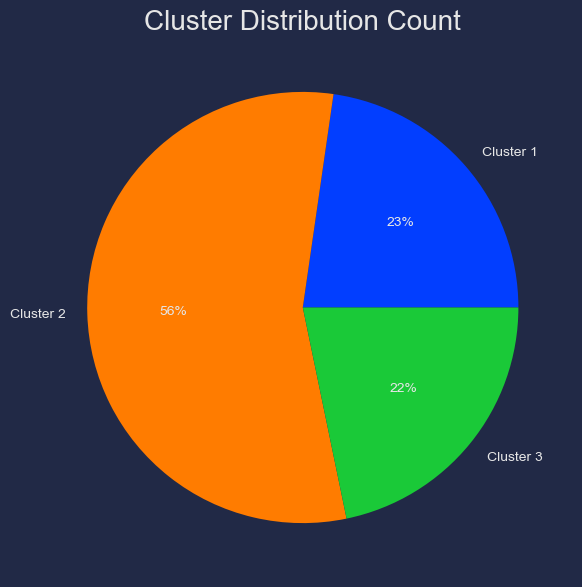

In [79]:
plt.figure(figsize=(12, 7))
colors = sns.color_palette('bright')
plt.pie(data, labels=labels, colors=colors, autopct='%.0f%%')
plt.title("Cluster Distribution Count", size=20)

## Aggregate user total traffic per application and derive the top 10 most engaged users per application

In [142]:
user_app_usage = df.groupby(
    'msisdn/number').agg({ 'social_media': 'sum', 'gaming': 'sum', 'youtube': 'sum', 'netflix': 'sum', 'google': 'sum', 'email': 'sum', 'other': 'sum'})

In [143]:
user_app_usage.head()

,social_media,gaming,youtube,netflix,google,email,other
msisdn/number,,,,,,,
3.360100e+10,11.113038,1.798127,1.868944,1.918426,1.790391,1.834217,1.887333
3.360100e+10,12.009616,1.826849,1.794261,1.686560,1.816914,1.929603,1.735823
3.360100e+10,11.760653,1.921198,1.805087,1.820467,1.623812,1.953866,1.878191
3.360101e+10,11.058215,1.804159,1.696890,1.523402,1.932918,1.793159,1.675161
3.360101e+10,22.146012,3.678801,3.681928,3.744760,3.826443,3.667828,3.754265


### Top 10 most engaged users per application

In [144]:
# Drop an outlier
user_app_usage.drop(33663706799.0, axis=0, inplace=True)

In [145]:
social_media = user_app_usage.nlargest(10, "social_media")['social_media']
gaming = user_app_usage.nlargest(10, "gaming")['gaming']
youtube = user_app_usage.nlargest(10, "youtube")['youtube']
netflix = user_app_usage.nlargest(10, "netflix")['netflix']
google = user_app_usage.nlargest(10, "google")['google']
email = user_app_usage.nlargest(10, "email")['email']
other = user_app_usage.nlargest(10, "other")['other']


In [146]:
social_media_df = pd.DataFrame()
social_media_df['User_ID'] = social_media.index
social_media_df['social_media'] = social_media.values
gaming_df = pd.DataFrame()
gaming_df['User_ID'] = gaming.index
gaming_df['gaming'] = gaming.values
youtube_df = pd.DataFrame()
youtube_df['User_ID'] = youtube.index
youtube_df['youtube'] = youtube.values

netflix_df = pd.DataFrame()
netflix_df['User_ID'] = netflix.index
netflix_df['netflix'] = netflix.values
google_df = pd.DataFrame()
google_df['User_ID'] = google.index
google_df['google'] = google.values
email_df = pd.DataFrame()
email_df['User_ID'] = email.index
email_df['email'] = email.values
others_df = pd.DataFrame()
others_df['User_ID'] = other.index
others_df['other'] = other.values

## Top 10 most engaged users per application


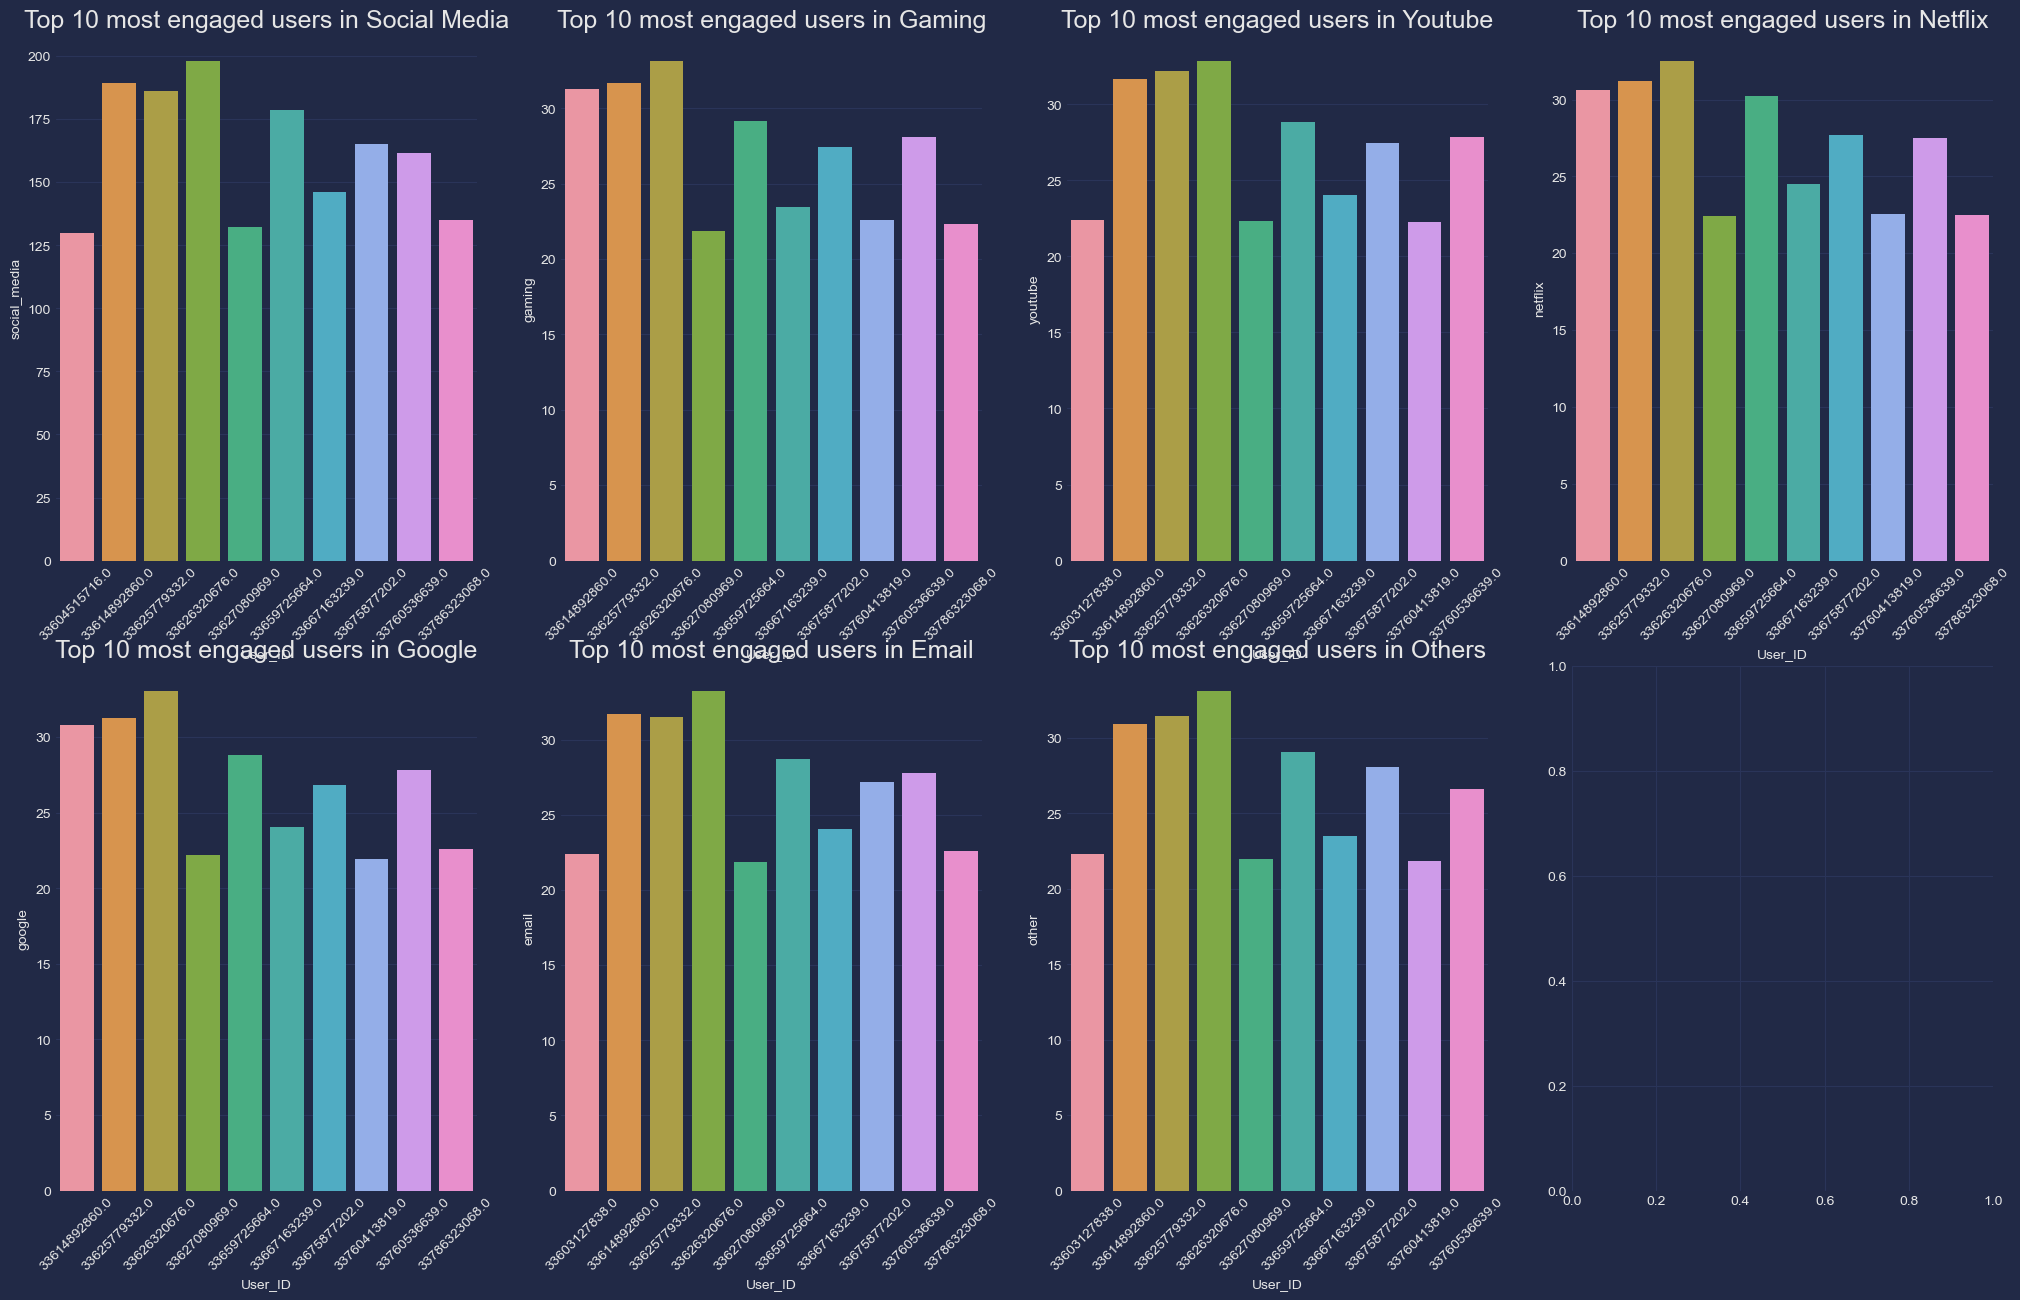

In [167]:
f, axes = plt.subplots(2, 4, figsize=(25, 15))
ax1 = sns.barplot(data=social_media_df, x='User_ID', orient='v', y='social_media', ax=axes[0,0])
ax2 = sns.barplot(data=gaming_df, x='User_ID',orient='v', y='gaming', ax=axes[0,1])
ax3 = sns.barplot(data=youtube_df, x='User_ID',orient='v', y='youtube', ax=axes[0,2])
ax4 = sns.barplot(data=netflix_df, x='User_ID',orient='v', y='netflix', ax=axes[0,3])
ax5 = sns.barplot(data=google_df, x='User_ID',orient='v', y='google', ax=axes[1,0])
ax6 = sns.barplot(data=email_df, x='User_ID',orient='v', y='email', ax=axes[1,1])
ax7 = sns.barplot(data=others_df, x='User_ID',orient='v', y='other', ax=axes[1,2])
ax1.set_xticklabels(ax1.xaxis.get_majorticklabels(), rotation=45)
ax2.set_xticklabels(ax2.xaxis.get_majorticklabels(), rotation=45)
ax3.set_xticklabels(ax3.xaxis.get_majorticklabels(), rotation=45)
ax4.set_xticklabels(ax4.xaxis.get_majorticklabels(), rotation=45)
ax5.set_xticklabels(ax5.xaxis.get_majorticklabels(), rotation=45)
ax6.set_xticklabels(ax6.xaxis.get_majorticklabels(), rotation=45)
ax7.set_xticklabels(ax7.xaxis.get_majorticklabels(), rotation=45)
ax1.set_title('Top 10 most engaged users in Social Media',fontsize=18)
ax2.set_title('Top 10 most engaged users in Gaming',fontsize=18)
ax3.set_title('Top 10 most engaged users in Youtube',fontsize=18)
ax4.set_title('Top 10 most engaged users in Netflix',fontsize=18)
ax5.set_title('Top 10 most engaged users in Google',fontsize=18)
ax6.set_title('Top 10 most engaged users in Email',fontsize=18)
ax7.set_title('Top 10 most engaged users in Others',fontsize=18)
plt.savefig('../assets/t10app_users.png')
plt.show()

### Plot the top 3 most used applications using appropriate charts.  

In [148]:
top_used_applications = user_app_usage.sum()

In [149]:
top_used_applications.values

array([           -inf, 274297.09102384, 274264.33138579, 275417.11011834,
       273719.13123421, 274460.45393203, 273019.34039492])

In [150]:
top_3_used = top_used_applications.nlargest(3)

In [151]:
top_3_used

netflix    275417.110118
email      274460.453932
gaming     274297.091024
dtype: float64

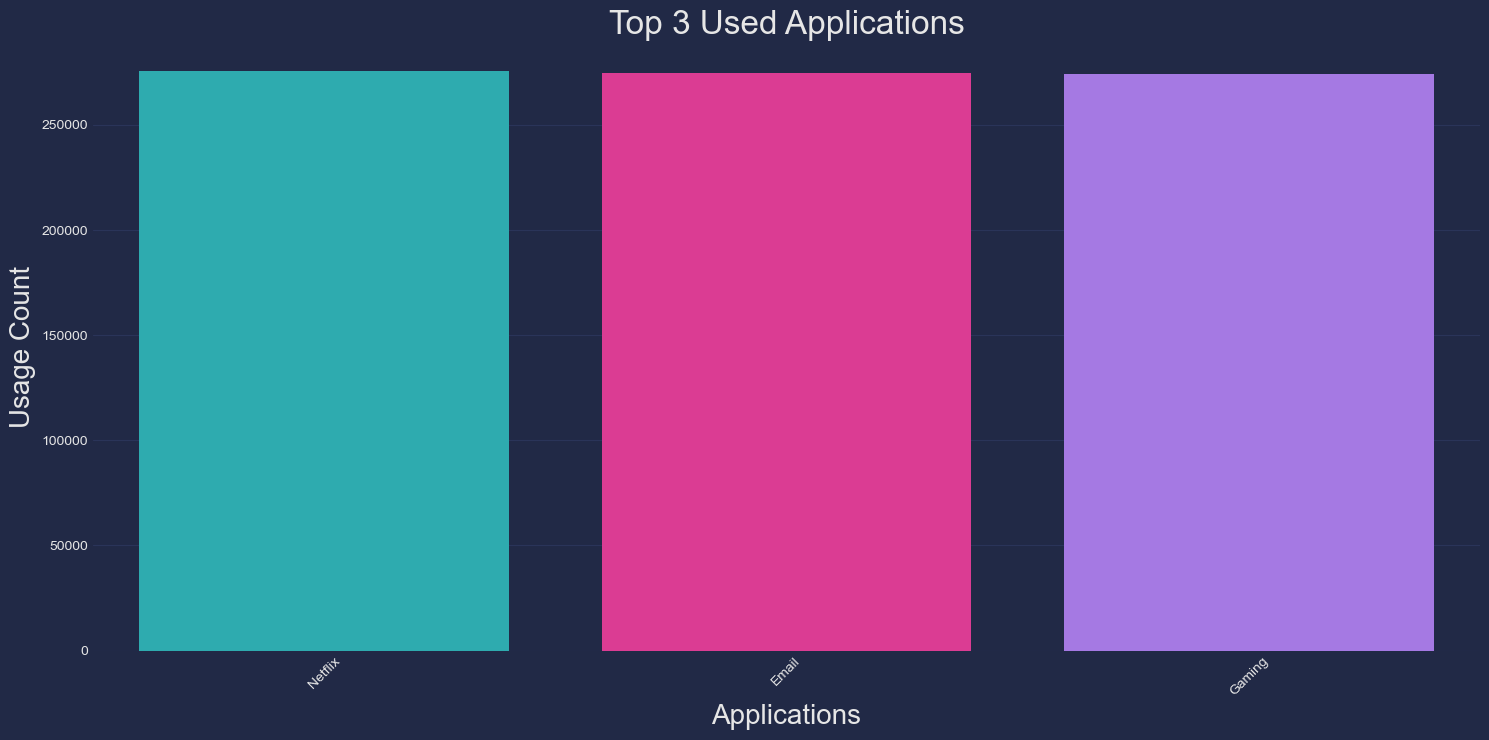

In [191]:
plt.figure(figsize=(15, 7.5))
ax = sns.barplot(y =top_3_used.values, x = ["Netflix", "Email", "Gaming"], data = top_3_used)
ax.tick_params(axis='x', rotation=45)

plt.xlabel("Applications",size=20)
plt.ylabel("Usage Count",size=20)
plt.title("Top 3 Used Applications", size=24)
plt.tight_layout()
plt.show()

### Using k-means clustering algorithm, group users in k engagement clusters based on the engagement metrics:

In [153]:
inertias = []
for i in range(1,16):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(normalized__eng)
    inertias.append(kmeans.inertia_)

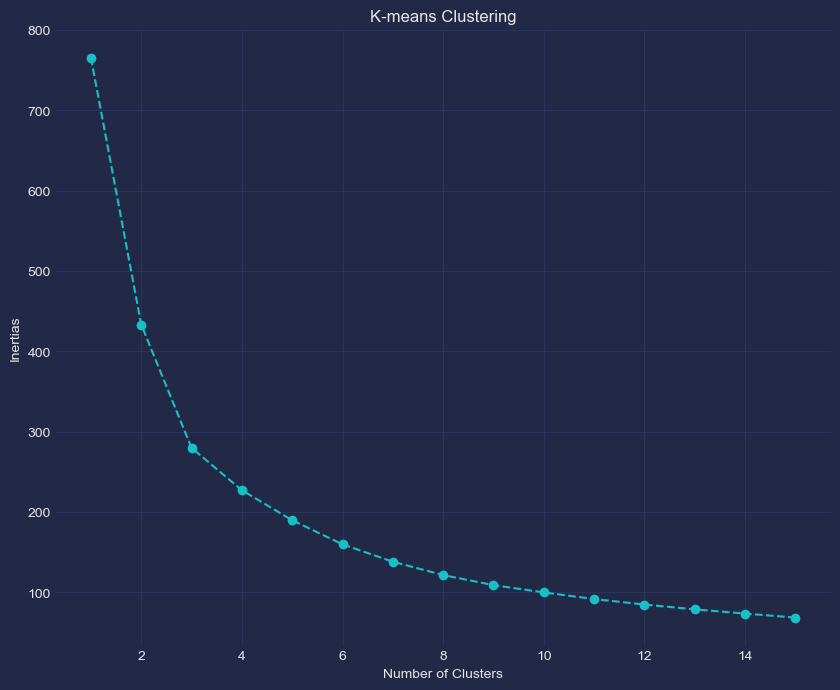

In [154]:
# Plotting the cluster size vs. inertia graph to find the optimal cluster
plt.figure(figsize = (10,8))
plt.plot(range(1, 16), inertias, marker = 'o', linestyle = '--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertias')
plt.title('K-means Clustering')
plt.show()

In [155]:
kl = KneeLocator(range(0, 15), inertias, curve="convex", direction="decreasing")
kl.elbow

3

In [156]:
logger.info(f"The optimal number of cluster is: {kl.elbow}")

## Interpretation

Using the elbow method, the optimal number of cluster is 3, which is the number of cluster I used above in the k-means clustering.

Save the result

In [157]:
u_eng.shape

(106855, 4)

In [158]:
with open("../models/user_eng.pkl", "wb") as f:
    pickle.dump(kmeans, f)

In [159]:
u_eng.to_csv('../data/user_eng.csv')

In [160]:
normalized__eng.to_csv('../data/normalized_eng.csv')